In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [ ]:
import numpy as np

x1 = np.load('dataset_nyuv2/x1.npy',mmap_mode='r')
x2 = np.load('dataset_nyuv2/x2.npy',mmap_mode='r')
# y = np.load('dataset_nyuv2/y.npy',mmap_mode='r')
y = np.load('dataset_nyuv2/y_prepared_65.npy',mmap_mode='r')
y = np.reshape(y, (1449, 96, 128, 66), order='F')


ValueError: cannot reshape array of size 17805312 into shape (1449,96,128,66)

In [ ]:
print('x1:')
print(type(x1[0]))
print(type(x1[0][0][0][0]))
print('\n x2:')
print(type(x2[0]))
print(type(x2[0][0][0][0]))
# print(x1.format)
# print(x1.mode)
print(x1[0].size)
print(x1[0].shape)
print(x2[0].shape)
print(y.shape)

x1:
<class 'numpy.memmap'>
<class 'numpy.float32'>

 x2:
<class 'numpy.memmap'>
<class 'numpy.float32'>
36864
(96, 128, 3)
(96, 128, 1)
(1449, 96, 128, 66)


In [ ]:
x1_train = x1[:1200]
x1_test = x1[1200:]
x2_train = x2[:1200]
x2_test = x2[1200:]
y_train = y[:1200]
y_test = y[1200:]

NameError: name 'y_show' is not defined

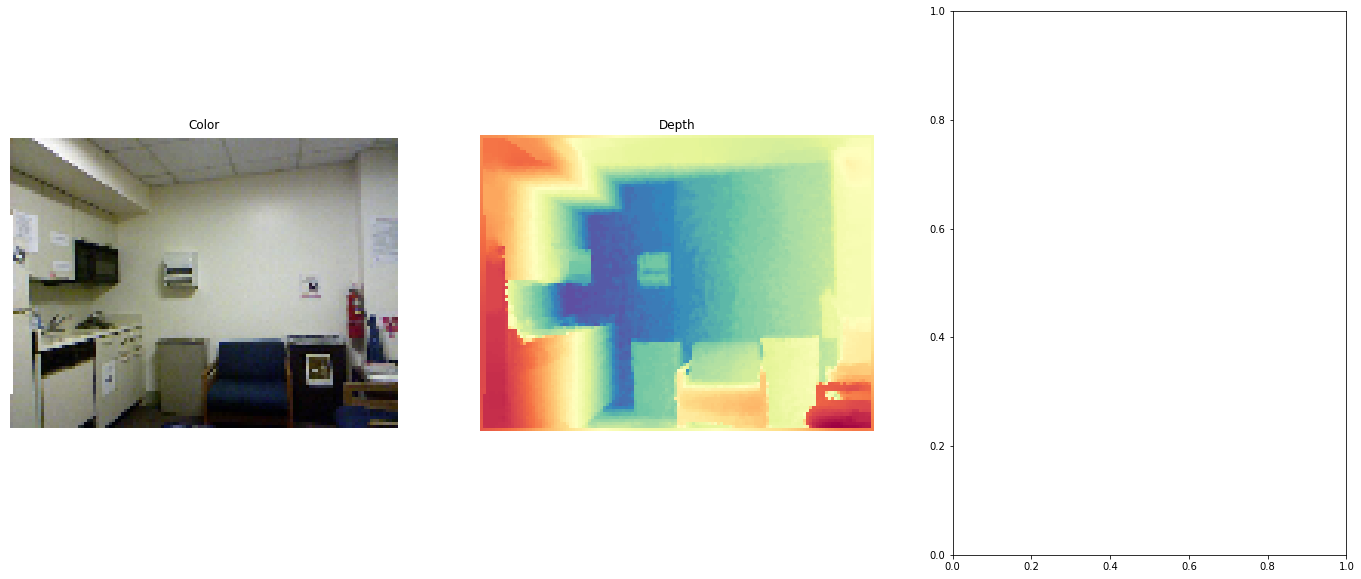

In [ ]:
import matplotlib.pyplot as plt
def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='Spectral')

def plot_label(ax, labels, title="Label"):
    """Displays a label map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(labels)

fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

number = 0

ax = fig.add_subplot(1, 3, 1)
plot_color(ax, x1[number])

ax = fig.add_subplot(1, 3, 2)
plot_depth(ax, np.asarray(x2[number]))

ax = fig.add_subplot(1, 3, 3)
plot_label(ax, y_show[number])

plt.show()

In [ ]:
class MyModel():

    def __init__(self):
        '''
        Crear el modelos para segmentación
        '''
        self.input_rgb = tf.keras.layers.Input(shape=(96,128,3),dtype=tf.float32,name='input_1')
        self.input_depth = tf.keras.layers.Input(shape=(96,128,1),dtype=tf.float32,name='input_2')
        self.fusion_1 = None
        self.fusion_2 = None

    def rgbd_fusion(self,input_r,input_d,capa):
        r = tf.keras.layers.GlobalAveragePooling2D()(input_r)
        r = tf.keras.layers.Reshape((1,1,32*capa))(r)
        r = tf.keras.layers.Conv2D(2*capa,kernel_size=(1,1),strides=(1,1),activation='relu')(r)
        r = tf.keras.layers.Conv2D(32*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(r)
        m_1 = tf.keras.layers.Multiply()([input_r,r])
        
        d = tf.keras.layers.GlobalAveragePooling2D()(input_d)
        d = tf.keras.layers.Reshape((1,1,32*capa))(d)
        d = tf.keras.layers.Conv2D(2*capa,kernel_size=(1,1),strides=(1,1),activation='relu')(d)
        d = tf.keras.layers.Conv2D(32*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(d)
        m_2 = tf.keras.layers.Multiply()([input_d,d])
        
        return tf.keras.layers.Add()([m_1,m_2])

    def resnet_layer(self,input_res, input_add, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x
    
    def resnet_layer_div(self,input_res, input_add, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same', strides=(2,1))(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same', strides=(1,2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)
        return x
    
    def bottleneck_layer(self,input_bo,filters):
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 1), activation='relu', padding='same')(input_bo)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 1), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, input_bo])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def decode_layer(self,input_de,input_add,filters):
        x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(input_de)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(x)
        x_2 = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), activation='relu', padding='same')(input_add)
        x = tf.keras.layers.Add()([x, x_2])

        return x
        
    def model(self):

        # Preparar la entrada de datos
        xr = tf.keras.layers.Conv2D(32,kernel_size=(7,7),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu')(self.input_rgb)
        xd = tf.keras.layers.Conv2D(32,kernel_size=(7,7),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu')(self.input_depth)

        # Fusion
        xr = self.rgbd_fusion(xr,xd,1)

        # Preparar para encoder
        xr = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(xr)
        xd = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(xd)

        ''' ENCODER'''
        # PRIMERA CAPA
        xr = self.resnet_layer(xr,xr,32)
        xd = self.resnet_layer(xd,xd,32)
        xr = self.resnet_layer(xr,xr,32)
        xd = self.resnet_layer(xd,xd,32)
        xr = self.resnet_layer(xr,xr,32)
        xd = self.resnet_layer(xd,xd,32)
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,1)
        self.fusion_1 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # SEGUNDA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(64,kernel_size=(1,1),strides=(2,2))(xr),64)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(64,kernel_size=(1,1),strides=(2,2))(xd),64)
        xr = self.resnet_layer(xr,xr,64)
        xd = self.resnet_layer(xd,xd,64)
        xr = self.resnet_layer(xr,xr,64)
        xd = self.resnet_layer(xd,xd,64)
        xr = self.resnet_layer(xr,xr,64)
        xd = self.resnet_layer(xd,xd,64)
        
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,2)
        self.fusion_2 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # TERCERA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2))(xr),128)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2))(xd),128)
        xr = self.resnet_layer(xr,xr,128)
        xd = self.resnet_layer(xd,xd,128)
        xr = self.resnet_layer(xr,xr,128)
        xd = self.resnet_layer(xd,xd,128)
        xr = self.resnet_layer(xr,xr,128)
        xd = self.resnet_layer(xd,xd,128)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,4)

        '''DECODER'''
        xr = self.decode_layer(xr,self.fusion_2,128)
        xr = self.decode_layer(xr,self.fusion_1,64)
        
        xr = tf.keras.layers.Conv2D(66, kernel_size=(3, 3), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(xr)
        xr = tf.keras.layers.Conv2D(66, kernel_size=(1, 1), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(xr)
        xr = tf.keras.layers.Conv2D(66, kernel_size=(1, 1), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.Conv2D(66, kernel_size=(1, 1), activation='softmax', padding='same')(xr)

        return tf.keras.Model(inputs=[self.input_rgb, self.input_depth], outputs=xr)

In [ ]:
model = MyModel().model()
model.summary()
# tf.keras.utils.plot_model(model,to_file="model.png")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 96, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 64, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 64, 32)   1600        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

In [ ]:
# miou = tf.keras.metrics.MeanIoU(num_classes, name=None, dtype=None)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(-epoch / 20))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)

model.compile(loss="binary_crossentropy", optimizer= "Adam", metrics =["accuracy"])

# Para utilizar el 20% para validación vamos a poner que realizen un split de 0,2
history = model.fit([x1_train,x2_train], y_train, epochs=1000, verbose=1,
#                     callbacks=[early_stopping
#                     ,lr_schedule], 
                    batch_size=16, validation_split=0.2)

Epoch 1/30


ValueError: in user code:

    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:1754 binary_crossentropy
        backend.binary_crossentropy(
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:5023 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\mikel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((16, 96, 128, 66) vs (16, 1, 96, 128))


In [ ]:
model.save("model.h5")

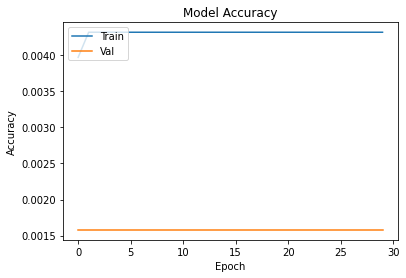

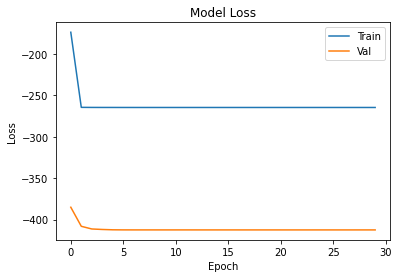

In [13]:
plot_acc(history)
plot_loss(history)

In [ ]:
results = model.predict([x1_test,x2_test])